<a href="https://colab.research.google.com/github/Davisdenner/MVP_Machine_Learning_Analytics/blob/main/MVP_Machine_Learning_Analytics3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics

**Nome:** Davis Denner Costa Silva

**Matrícula:** 4052025000133

**Dataset:** [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

**Link para o repositório no GitHub:** [MVP - Machine Learning & Analytics](https://github.com/Davisdenner/MVP_Machine_Learning_Analytics)


# Descrição do Problema
Em situações de desastres naturais, informações relevantes são frequentemente compartilhadas em tempo real por meio de redes sociais, como o Twitter. Entretanto, diferenciar tweets que realmente descrevem eventos de desastre daqueles que apenas mencionam o tema de forma indireta é um desafio.

Este projeto tem como objetivo classificar automaticamente tweets relacionados a desastres naturais utilizando técnicas de Deep Learning e Processamento de Linguagem Natural (NLP). Para isso, foi utilizado o conjunto de dados [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started), disponibilizado no Kaggle, que contém milhares de tweets rotulados entre mensagens relacionadas e não relacionadas a desastres.

##Objetivo do Projeto

Desenvolver e implementar um sistema de classificação automática de textos relacionados a desastres, utilizando técnicas de Processamento de Linguagem Natural (NLP) e redes neurais profundas. O projeto busca aplicar bibliotecas como TensorFlow/Keras, NLTK e scikit-learn para realizar o pré-processamento de dados, análise exploratória, treinamento e avaliação de diferentes arquiteturas de modelos, visando criar uma solução capaz de identificar, com alta precisão, conteúdos associados a situações de emergência.

## Hipóteses do Problema

Explorar a relação entre o conteúdo textual de tweets e a correta identificação de mensagens relacionadas a desastres naturais, com base nas seguintes perguntas:

- Quais características do texto mais contribuem para identificar se um tweet descreve um desastre real?

- Tweets que contêm palavras-chave específicas têm maior probabilidade de estarem relacionados a desastres?


## Tipo de Problema

Este é um problema de aprendizado supervisionado, pois o conjunto de dados contém tweets previamente rotulados como relacionados ou não a desastres. O objetivo é treinar modelos de Deep Learning capazes de aprender a partir desses exemplos e, futuramente, classificar automaticamente novos tweets, prevendo se o conteúdo está associado ou não a um evento de desastre.

##Atributos do Dataset

O projeto utiliza dois conjuntos de dados fornecidos pelo Kaggle: **train.csv** e **test.csv**. Ambos contêm tweets que podem ou não estar relacionados a desastres, mas diferem na presença da variável alvo.

---

### **1. Dataset de Treinamento — train.csv**  
Contém os tweets **rotulados**, utilizados para **treinar** e **avaliar** os modelos de classificação.

| **Atributo**    |         **Descrição** |
|-----------------------|---------------|
| **id**      | Identificador único de cada tweet. |
| **keyword** | Palavra-chave associada ao tweet (pode estar ausente). |
| **location** | Localidade mencionada no tweet (pode estar ausente). |
| **text**    | Texto completo do tweet, utilizado para análise e treinamento. |
| **target**  | Variável alvo: **1** se o tweet está relacionado a um desastre e **0** caso contrário. |

---

### **2. Dataset de Teste — test.csv**  
Contém tweets **não rotulados**, utilizados para **avaliar a performance** do modelo após o treinamento.

| **Atributo** | **Descrição** |
|-------------|---------------|
| **id**      | Identificador único de cada tweet. |
| **keyword** | Palavra-chave associada ao tweet (pode estar ausente). |
| **location** | Localidade mencionada no tweet (pode estar ausente). |
| **text**    | Texto completo do tweet, utilizado para previsão. |

**Observação:** Diferente do dataset de treino, o arquivo **test.csv** não contém a coluna **target**, pois seu objetivo é testar a capacidade de generalização do modelo.


# Importação das Bibliotecas Necessárias e Carga de Dados

Nesta etapa, foram importadas todas as bibliotecas necessárias para manipulação de dados, visualização, processamento de texto e construção do modelo de Deep Learning.

**Bibliotecas Principais**

- NumPy e Pandas - Manipulação de arrays e tabelas;

- Matplotlib e Seaborn - Visualização de gráficos;

- re - Expressões regulares para limpeza de texto;

- Counter - Contagem de palavras, hashtags e termos mais frequentes.

**Bibliotecas de Deep Learning**

- TensorFlow / Keras - Criação, treinamento e otimização de modelos de Deep Learning;

- LSTM & Bidirectional - Redes neurais recorrentes para análise sequencial de texto;

- Embedding - Conversão de palavras em vetores numéricos;

- train_test_split - Divisão do dataset em conjuntos de treino e teste para validação do modelo;

- classification_report - Avaliação detalhada do desempenho do modelo, incluindo precisão, recall e F1-score;

- confusion_matrix - Matriz de confusão para análise de acertos e erros de classificação;

- Callbacks - Ajuste dinâmico do treinamento para evitar overfitting.

**Otimização de Hiperparâmetros**

- Utilizaremos GridSearchCV para testar diferentes combinações de hiperparâmetros e encontrar a configuração ideal para o modelo.

**Visualizações Interativas**

- Plotly - Visualizações interativas e dinâmicas;

- WordCloud - Geração de nuvens de palavras para explorar termos mais frequentes.

**Processamento de Texto**

- NLTK - Biblioteca para processamento e análise de linguagem natural;

- Stopwords - Remoção de palavras irrelevantes;

- Tokenização - Separação do texto em palavras;

- Lematização - Redução das palavras à sua forma base.

**Configurações Opcionais**

- warnings.filterwarnings - Oculta mensagens de aviso;

- Seaborn Style - Define o estilo padrão dos gráficos;

- %matplotlib inline - Exibe gráficos diretamente no notebook.


In [31]:
# ============================================================================#
# PROJETO DE DEEP LEARNING PARA PROCESSAMENTO DE LINGUAGEM NATURAL
# Problema: Classificação de Tweets de Desastre
# ============================================================================#

#Imports necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

#Bibliotecas de Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#Otimização de hiperparâmetros
from sklearn.model_selection import GridSearchCV

#Para visualizações
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

#Para processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Configuração para não exibir warnings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
%matplotlib inline


# Carga e Exploração dos Dados

Nesta etapa, foi realizada a importação dos dados, foram baixados os recursos necessários para o processamento de linguagem natural (NLP) e foi feita uma análise exploratória inicial para entender melhor o conjunto de dados.



=== ANÁLISE EXPLORATÓRIA DOS DADOS ===
Dimensões do conjunto de treino: (7613, 5)
Dimensões do conjunto de teste: (3263, 4)

Valores nulos no treino: 2594
Valores nulos no teste: 1131

Distribuição da variável target:
target
0    4342
1    3271
Name: count, dtype: int64
Proporção: 57.03% Não-Desastre, 42.97% Desastre


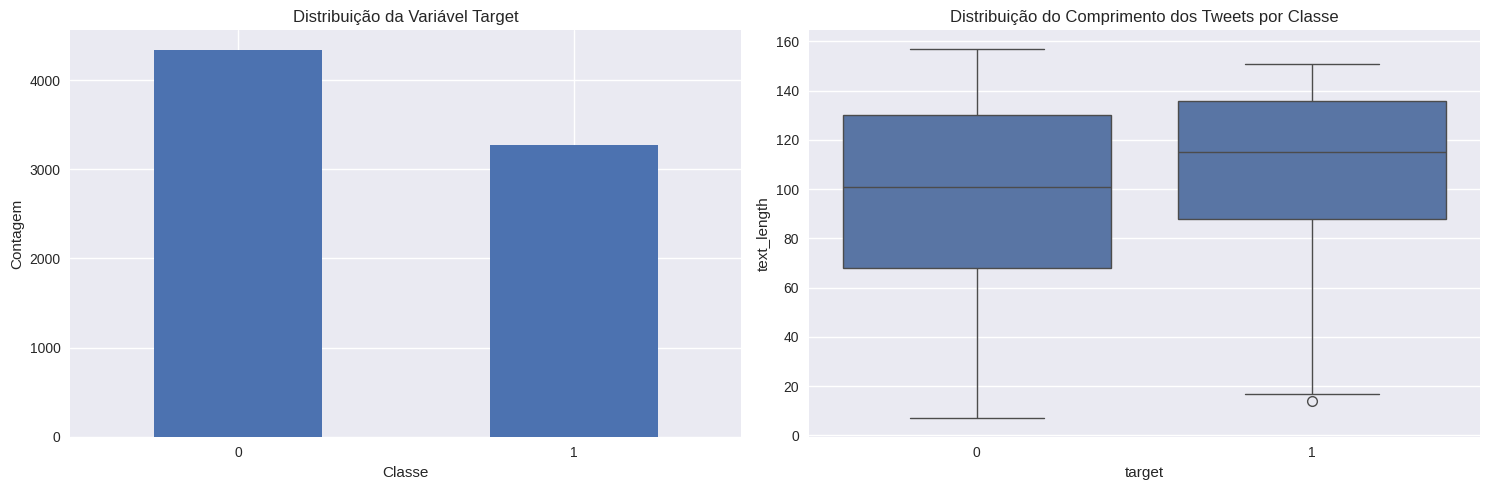

In [32]:
# ============================================================================
# 1. CARGA E EXPLORAÇÃO DOS DADOS
# ============================================================================

#Baixando recursos do NLTK necessários
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

#Carregando os dados
train_df = pd.read_csv(r"https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/test.csv")

print("=== ANÁLISE EXPLORATÓRIA DOS DADOS ===")
print(f"Dimensões do conjunto de treino: {train_df.shape}")
print(f"Dimensões do conjunto de teste: {test_df.shape}")

#Verificando valores nulos
print(f"\nValores nulos no treino: {train_df.isnull().sum().sum()}")
print(f"Valores nulos no teste: {test_df.isnull().sum().sum()}")

#Distribuição da variável target
print(f"\nDistribuição da variável target:")
target_dist = train_df['target'].value_counts()
print(target_dist)
print(f"Proporção: {target_dist[0] / len(train_df):.2%} Não-Desastre, {target_dist[1] / len(train_df):.2%} Desastre")

#Visualização da distribuição
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Contagem
train_df['target'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição da Variável Target')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Contagem')
axes[0].tick_params(axis='x', rotation=0)

#Comprimento dos tweets
train_df['text_length'] = train_df['text'].apply(len)
sns.boxplot(x='target', y='text_length', data=train_df, ax=axes[1])
axes[1].set_title('Distribuição do Comprimento dos Tweets por Classe')

plt.tight_layout()
plt.show()

In [33]:
# ============================================================================
# 2. PREPARAÇÃO E PRÉ-PROCESSAMENTO DOS DADOS
# ============================================================================

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    #Convertendo para minúsculo
    text = text.lower()

    #Removendo URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    #Removendo menções e hashtags (manter o conteúdo)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    #Removendo caracteres especiais, manter espaços
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Removendo espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    #Tokenização
    tokens = word_tokenize(text)


    #Removendo stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    #Lematização
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


#Aplicando pré-processamento
print("Aplicando pré-processamento nos dados...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

#Estatísticas do texto processado
print(f"Textos vazios após processamento (treino): {train_df['processed_text'].str.len().eq(0).sum()}")
print(f"Comprimento médio do texto processado: {train_df['processed_text'].str.len().mean():.1f}")

#Removendo textos vazios
train_df = train_df[train_df['processed_text'].str.len() > 0]
print(f"Dados restantes após limpeza: {len(train_df)}")

Aplicando pré-processamento nos dados...
Textos vazios após processamento (treino): 1
Comprimento médio do texto processado: 57.9
Dados restantes após limpeza: 7612


Tamanhos dos conjuntos:
Treino: 6089 (80.0%)
Validação: 1523 (20.0%)
Teste: 3263


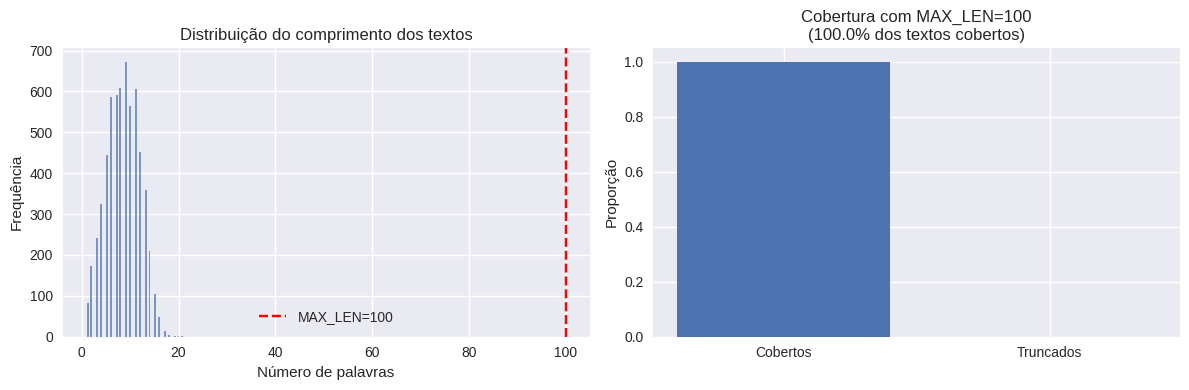


Após tokenização e padding:
Shape treino: (6089, 100)
Shape validação: (1523, 100)
Shape teste: (3263, 100)
Tamanho do vocabulário: 11482


In [34]:
# ============================================================================
# 3. SEPARAÇÃO TREINO/VALIDAÇÃO/TESTE E TOKENIZAÇÃO
# ============================================================================

#Preparando dados
X = train_df['processed_text']
y = train_df['target']

#Divisão estratificada treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanhos dos conjuntos:")
print(f"Treino: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validação: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Teste: {len(test_df)}")

#Configurações para tokenização
MAX_FEATURES = 20000  #Tamanho do vocabulário
MAX_LEN = 100  #Comprimento máximo das sequências

#Análise do comprimento das sequências
text_lengths = X_train.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, alpha=0.7)
plt.axvline(MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN={MAX_LEN}')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.title('Distribuição do comprimento dos textos')
plt.legend()

plt.subplot(1, 2, 2)
coverage = (text_lengths <= MAX_LEN).mean()
plt.bar(['Cobertos', 'Truncados'], [coverage, 1 - coverage])
plt.title(f'Cobertura com MAX_LEN={MAX_LEN}\n({coverage:.1%} dos textos cobertos)')
plt.ylabel('Proporção')

plt.tight_layout()
plt.show()

#Tokenização
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

#Convertendo textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

#Padding das sequências
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"\nApós tokenização e padding:")
print(f"Shape treino: {X_train_pad.shape}")
print(f"Shape validação: {X_val_pad.shape}")
print(f"Shape teste: {X_test_pad.shape}")
print(f"Tamanho do vocabulário: {len(tokenizer.word_index)}")

In [35]:
# ============================================================================
# 4. MODELOS DE DEEP LEARNING - ARQUITETURAS DIFERENTES
# ============================================================================

from tensorflow.keras.layers import GlobalMaxPool1D # Importando GlobalMaxPool1D


def create_simple_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_bidirectional_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
        GlobalMaxPool1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model




#Criando todos os modelos
models = {
    'LSTM_Simples': create_simple_lstm(MAX_FEATURES),
    'LSTM_Bidirecional': create_bidirectional_lstm(MAX_FEATURES),

}

#Mostrando arquiteturas
for name, model in models.items():
    print(f"\n=== ARQUITETURA {name} ===")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, MAX_LEN))  # Construir o modelo
    print(f"Parâmetros treináveis: {model.count_params():,}")


=== ARQUITETURA LSTM_Simples ===
Parâmetros treináveis: 2,611,521

=== ARQUITETURA LSTM_Bidirecional ===
Parâmetros treináveis: 2,669,185


In [36]:
# ============================================================================
# 5. TREINAMENTO DOS MODELOS
# ============================================================================

#Callbacks para otimização do treinamento
#callbacks = [
    #EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=1)
#]


#Dicionário para armazenar históricos e resultados
#results = {}
#histories = {}

#print("=== INICIANDO TREINAMENTO DOS MODELOS ===\n")

#for name, model in models.items():
    #print(f"Treinando {name}...")

    #Treinando modelo
    #history = model.fit(
        #X_train_pad, y_train,
        #epochs=3,
        #batch_size=128,
        #validation_data=(X_val_pad, y_val),
        #callbacks=callbacks,
        #verbose=1
    #)

    #Avaliando o modelo
    #val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
    #y_pred = (model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()

    #Armazenando os resultados
    #results[name] = {
        #'model': model,
        #'val_loss': val_loss,
        #'val_accuracy': val_accuracy,
        #'predictions': y_pred,
        #'epochs_trained': len(history.history['loss'])
    #}
    #histories[name] = history.history

    #print(f" {name}: Acurácia = {val_accuracy:.4f}, Loss = {val_loss:.4f}, Épocas = {len(history.history['loss'])}\n")

#print("=== TREINAMENTO CONCLUÍDO ===")

In [37]:
# ============================================================================
# 6. OTIMIZAÇÃO DE HIPERPARÂMETROS (MELHOR MODELO)
# ============================================================================

#Identificando o melhor modelo base
#best_base_model = max(results.keys(), key=lambda k: results[k]['val_accuracy'])
#print(f"Melhor modelo base: {best_base_model} (Acurácia: {results[best_base_model]['val_accuracy']:.4f})")


#Otimização de hiperparâmetros para o melhor modelo
#def create_optimized_model(embedding_dim=128, lstm_units=64, dense_units=64, dropout_rate=0.5, learning_rate=0.001):
    #model = Sequential([
        #Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN),
        #Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        #GlobalMaxPool1D(),
        #Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)),
        #Dropout(dropout_rate),
        #Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.01)),
        #Dropout(dropout_rate / 2),
        #Dense(1, activation='sigmoid')
    #])

    #optimizer = Adam(learning_rate=learning_rate)
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    #return model


#Configurações de hiperparâmetros para testar
#hyperparams_configs = [
    #{'embedding_dim': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001},
    #{'embedding_dim': 128, 'lstm_units': 100, 'dense_units': 80, 'dropout_rate': 0.6, 'learning_rate': 0.002}
#]

#print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===")
#best_hyperparams = None
#best_hp_score = 0

#for i, params in enumerate(hyperparams_configs):
    #print(f"\nTestando configuração {i + 1}: {params}")

    #Criando e treinar modelo
    #model = create_optimized_model(**params)

    #history = model.fit(
        #X_train_pad, y_train,
        #epochs=5,
        #batch_size=128,
        #validation_data=(X_val_pad, y_val),
        #callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        #verbose=1
    #)

    #Avaliando
    #val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
    #print(f"Acurácia: {val_accuracy:.4f}")

    #if val_accuracy > best_hp_score:
        #best_hp_score = val_accuracy
        #best_hyperparams = params
        #best_optimized_model = model

#print(f"\n Melhores hiperparâmetros: {best_hyperparams}")
#print(f" Melhor acurácia otimizada: {best_hp_score:.4f}")

In [38]:
# ============================================================================
# CARREGANDO OS MODELOS TREINADOS
# ============================================================================

loaded_models = {}

model_names_to_load = ['LSTM_Simples', 'LSTM_Bidirecional']

print("=== CARREGANDO MODELOS TREINADOS ===")

for model_name in model_names_to_load:
    model_load_path = f'{model_name}_best_model.keras'
    print(f"Tentando carregar o modelo de: {model_load_path}")

    try:
        loaded_model = keras.models.load_model(model_load_path)
        print(f"Modelo '{model_name}' carregado com sucesso!")
        loaded_models[model_name] = loaded_model
    except Exception as e:
        print(f"Erro ao carregar o modelo '{model_name}': {e}")
        print(f"Certifique-se de que o arquivo '{model_load_path}' existe no caminho especificado.")

# Verificar se ambos os modelos foram carregados
if len(loaded_models) == len(model_names_to_load):
    print("\nAmbos os modelos foram carregados e estão disponíveis no dicionário 'loaded_models'.")
else:
    print("\nAlguns modelos não foram carregados. Verifique as mensagens de erro acima.")

=== CARREGANDO MODELOS TREINADOS ===
Tentando carregar o modelo de: LSTM_Simples_best_model.keras
Modelo 'LSTM_Simples' carregado com sucesso!
Tentando carregar o modelo de: LSTM_Bidirecional_best_model.keras
Modelo 'LSTM_Bidirecional' carregado com sucesso!

Ambos os modelos foram carregados e estão disponíveis no dicionário 'loaded_models'.


=== COMPARAÇÃO FINAL DOS MODELOS DE DEEP LEARNING ===
              Modelo  Acurácia           Tipo
1  LSTM_Bidirecional    0.8148  Deep Learning
0       LSTM_Simples    0.8089  Deep Learning

=== ANÁLISE COMPARATIVA ===
Melhor modelo: LSTM_Bidirecional (Acurácia: 0.8148)
• LSTM_Simples: 0.8089 (diferença: -0.0059)


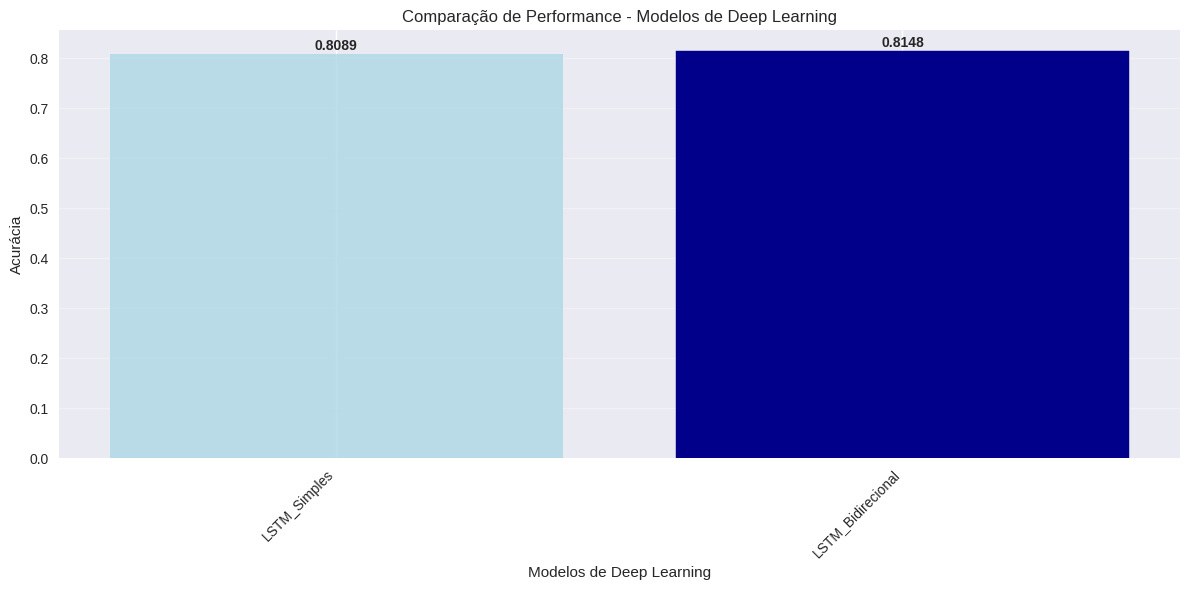


=== ESTATÍSTICAS DOS MODELOS DE DEEP LEARNING ===
Total de modelos avaliados: 2
Acurácia média: 0.8119
Desvio padrão: 0.0042
Variação (máx - mín): 0.0059

 Modelo selecionado para predições finais: LSTM_Bidirecional
 Acurácia na validação: 0.8148


In [39]:
# ============================================================================
# 7. AVALIAÇÃO E COMPARAÇÃO DOS RESULTADOS - DEEP LEARNING
# ============================================================================

#Adicionando modelo otimizado aos resultados
#y_pred_optimized = (best_optimized_model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()
#results['LSTM_Otimizado'] = {
    #'model': best_optimized_model,
    #'val_accuracy': best_hp_score,
    #'predictions': y_pred_optimized
#}



#Comparando de resultados
dl_results = {k: v for k, v in results.items() if 'model' in v}

comparison_df = pd.DataFrame({
    'Modelo': list(dl_results.keys()),
    'Acurácia': [dl_results[k]['val_accuracy'] for k in dl_results.keys()],
    'Tipo': ['Deep Learning'] * len(dl_results)
})

print("=== COMPARAÇÃO FINAL DOS MODELOS DE DEEP LEARNING ===")
comparison_sorted = comparison_df.sort_values('Acurácia', ascending=False)
print(comparison_sorted.round(4))

#Mostrando diferenças entre modelos
best_dl_acc = comparison_sorted.iloc[0]['Acurácia']
print(f"\n=== ANÁLISE COMPARATIVA ===")
print(f"Melhor modelo: {comparison_sorted.iloc[0]['Modelo']} (Acurácia: {best_dl_acc:.4f})")
for i in range(1, len(comparison_sorted)):
    model_name = comparison_sorted.iloc[i]['Modelo']
    model_acc = comparison_sorted.iloc[i]['Acurácia']
    diff = best_dl_acc - model_acc
    print(f"• {model_name}: {model_acc:.4f} (diferença: -{diff:.4f})")

#Visualização comparativa
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(comparison_df)), comparison_df['Acurácia'],
               color='lightblue', alpha=0.8)
plt.xlabel('Modelos de Deep Learning')
plt.ylabel('Acurácia')
plt.title('Comparação de Performance - Modelos de Deep Learning')
plt.xticks(range(len(comparison_df)), comparison_df['Modelo'], rotation=45, ha='right')

#Adicionando valores nas barras
for bar, acc in zip(bars, comparison_df['Acurácia']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

#Destacando o melhor modelo
best_idx = comparison_df['Acurácia'].idxmax()
bars[best_idx].set_color('darkblue')
bars[best_idx].set_alpha(1.0)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#Estatísticas adicionais dos modelos DL
print(f"\n=== ESTATÍSTICAS DOS MODELOS DE DEEP LEARNING ===")
print(f"Total de modelos avaliados: {len(dl_results)}")
print(f"Acurácia média: {comparison_df['Acurácia'].mean():.4f}")
print(f"Desvio padrão: {comparison_df['Acurácia'].std():.4f}")
print(f"Variação (máx - mín): {comparison_df['Acurácia'].max() - comparison_df['Acurácia'].min():.4f}")

#Identificando o melhor modelo para uso posterior
best_dl_model_name = comparison_sorted.iloc[0]['Modelo']
best_dl_model = dl_results[best_dl_model_name]['model']

print(f"\n Modelo selecionado para predições finais: {best_dl_model_name}")
print(f" Acurácia na validação: {dl_results[best_dl_model_name]['val_accuracy']:.4f}")

=== MODELOS DE DEEP LEARNING DISPONÍVEIS ===
• LSTM_Simples: Acurácia 0.8089
• LSTM_Bidirecional: Acurácia 0.8148

=== ANÁLISE DO MELHOR MODELO: LSTM_Bidirecional ===
Acurácia: 0.8148
Tipo: Deep Learning Neural Network

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

Não Desastre       0.82      0.86      0.84       869
    Desastre       0.80      0.75      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523



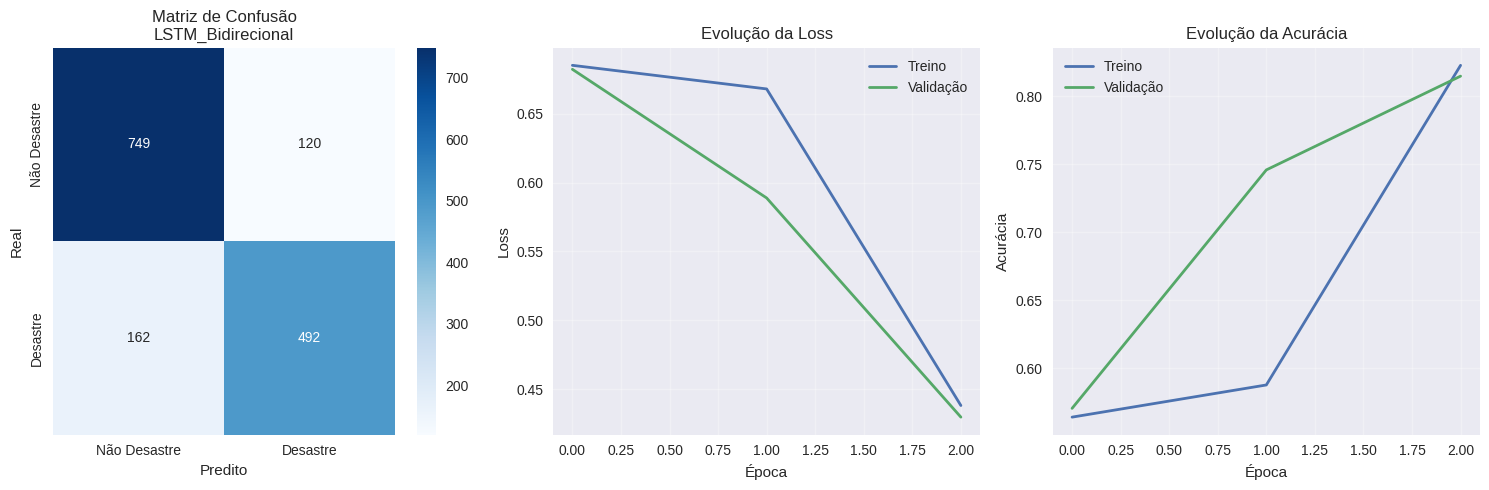


=== ANÁLISE DE ERROS ===
Total de predições corretas: 1241 (81.5%)
Total de predições incorretas: 282 (18.5%)

Tipos de erro:
• Falsos Positivos: 120 (7.9%)
• Falsos Negativos: 162 (10.6%)

=== EXEMPLOS DE FALSOS POSITIVOS ===
(Predito como desastre, mas não é)
1. step one get mass murderer portrait yuan...
2. firefighter acted like cop theyd drive around shooting flamethrower burning building...
3. get pic show trophy outbreak photoshop...

=== EXEMPLOS DE FALSOS NEGATIVOS ===
(Predito como não-desastre, mas é)
1. hollywood movie trapped miner released chile hollywood movie trapped miner starring...
2. dad said look thinner usual really like...
3. cant drown demon know swim...

 Modelo LSTM_Bidirecional pronto para predições finais!


In [40]:
# ============================================================================
# 8. ANÁLISE DETALHADA DO MELHOR MODELO DE DEEP LEARNING
# ============================================================================

dl_results = {k: v for k, v in results.items() if 'model' in v and v['model'] is not None}

print("=== MODELOS DE DEEP LEARNING DISPONÍVEIS ===")
for modelo_nome, dados_modelo in dl_results.items():
    print(f"• {modelo_nome}: Acurácia {dados_modelo['val_accuracy']:.4f}")

#Identificando o melhor modelo de Deep Learning
best_model_name = max(dl_results.keys(), key=lambda k: dl_results[k]['val_accuracy'])
best_model = dl_results[best_model_name]['model']
best_predictions = dl_results[best_model_name]['predictions']

print(f"\n=== ANÁLISE DO MELHOR MODELO: {best_model_name} ===")
print(f"Acurácia: {dl_results[best_model_name]['val_accuracy']:.4f}")
print(f"Tipo: Deep Learning Neural Network")

#Relatório de classificação detalhado
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_val, best_predictions, target_names=['Não Desastre', 'Desastre']))

#Matriz de confusão e curvas de treinamento
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Desastre', 'Desastre'],
            yticklabels=['Não Desastre', 'Desastre'])
plt.title(f'Matriz de Confusão\n{best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')

#Curvas de treinamento
if best_model_name in histories:
    history = histories[best_model_name]

    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Treino', linewidth=2)
    plt.plot(history['val_loss'], label='Validação', linewidth=2)
    plt.title('Evolução da Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(history['accuracy'], label='Treino', linewidth=2)
    plt.plot(history['val_accuracy'], label='Validação', linewidth=2)
    plt.title('Evolução da Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Análise de erros
errors_df = pd.DataFrame({
    'text': X_val.values,
    'true_label': y_val.values,
    'predicted_label': best_predictions,
    'correct': y_val.values == best_predictions
})

print(f"\n=== ANÁLISE DE ERROS ===")
print(f"Total de predições corretas: {errors_df['correct'].sum()} ({errors_df['correct'].mean():.1%})")
print(f"Total de predições incorretas: {(~errors_df['correct']).sum()} ({(~errors_df['correct']).mean():.1%})")

#Análise detalhada dos erros
false_positives = errors_df[(errors_df['true_label'] == 0) & (errors_df['predicted_label'] == 1)]
false_negatives = errors_df[(errors_df['true_label'] == 1) & (errors_df['predicted_label'] == 0)]

print(f"\nTipos de erro:")
print(f"• Falsos Positivos: {len(false_positives)} ({len(false_positives)/len(errors_df):.1%})")
print(f"• Falsos Negativos: {len(false_negatives)} ({len(false_negatives)/len(errors_df):.1%})")

#Exemplos de erros
if len(false_positives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS POSITIVOS ===")
    print("(Predito como desastre, mas não é)")
    for i in range(min(3, len(false_positives))):
        print(f"{i+1}. {false_positives.iloc[i]['text'][:100]}...")

if len(false_negatives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS NEGATIVOS ===")
    print("(Predito como não-desastre, mas é)")
    for i in range(min(3, len(false_negatives))):
        print(f"{i+1}. {false_negatives.iloc[i]['text'][:100]}...")

print(f"\n Modelo {best_model_name} pronto para predições finais!")

=== PREDIÇÕES FINAIS COM MODELO DE DEEP LEARNING ===
Modelo utilizado: LSTM_Bidirecional
Acurácia na validação: 0.8148

=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===
Não Desastre: 2,018 (61.8%)
Desastre: 1,245 (38.2%)

=== ESTATÍSTICAS DAS PROBABILIDADES ===
Média: 0.426
Mediana: 0.277
Desvio padrão: 0.323
Mínimo: 0.025
Máximo: 0.999


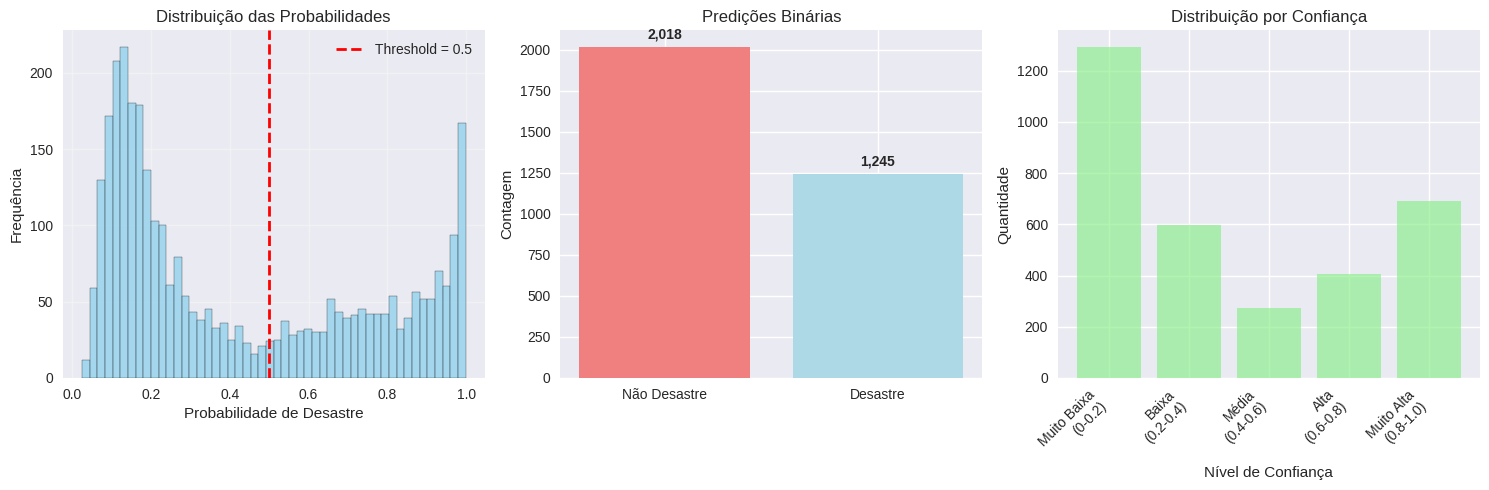


=== ANÁLISE DE CONFIANÇA ===
Alta confiança DESASTRE (>90%): 446 tweets
Alta confiança NÃO-DESASTRE (<10%): 356 tweets
Predições incertas (40-60%): 273 tweets
Total com alta confiança: 802 tweets (24.6%)

=== EXEMPLOS: DESASTRE (Alta Confiança) ===
1. Probabilidade: 0.908
   Texto original: Apocalypse lighting. #Spokane #wildfires...

2. Probabilidade: 0.946
   Texto original: Typhoon Soudelor kills 28 in China and Taiwan...

3. Probabilidade: 0.902
   Texto original: Rape victim dies as she sets herself ablaze: A 16-year-old girl died of burn injuries as she set her...

=== EXEMPLOS: NÃO-DESASTRE (Alta Confiança) ===
1. Probabilidade: 0.072
   Texto original: Please like and share our new page for our Indoor Trampoline Park Aftershock opening this fall!! htt...

2. Probabilidade: 0.097
   Texto original: Schoolboy ÛÒ Aftershock (Original Mix)
Excision &amp; Skism ÛÒ SEXisM (Far Too Loud Remix)
Firebea...

3. Probabilidade: 0.051
   Texto original: 320 [IR] ICEMOON [AFTERSHOCK] | ht

In [41]:

# ============================================================================
# 9. PREDIÇÕES FINAIS NO CONJUNTO DE TESTE
# ============================================================================

print("=== PREDIÇÕES FINAIS COM MODELO DE DEEP LEARNING ===")
print(f"Modelo utilizado: {best_model_name}")
print(f"Acurácia na validação: {dl_results[best_model_name]['val_accuracy']:.4f}")

#Fazendo predições no conjunto de teste
test_predictions = best_model.predict(X_test_pad, verbose=0)
test_predictions_proba = test_predictions.flatten()
test_predictions_binary = (test_predictions_proba > 0.5).astype(int)

#Estatísticas das predições
print(f"\n=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===")
test_dist = pd.Series(test_predictions_binary).value_counts()
print(f"Não Desastre: {test_dist[0]:,} ({test_dist[0] / len(test_predictions_binary):.1%})")
print(f"Desastre: {test_dist[1]:,} ({test_dist[1] / len(test_predictions_binary):.1%})")

#Análise das probabilidades
prob_stats = pd.Series(test_predictions_proba).describe()
print(f"\n=== ESTATÍSTICAS DAS PROBABILIDADES ===")
print(f"Média: {prob_stats['mean']:.3f}")
print(f"Mediana: {prob_stats['50%']:.3f}")
print(f"Desvio padrão: {prob_stats['std']:.3f}")
print(f"Mínimo: {prob_stats['min']:.3f}")
print(f"Máximo: {prob_stats['max']:.3f}")

#Distribuição das probabilidades e predições
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(test_predictions_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Probabilidade de Desastre')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
colors = ['lightcoral', 'lightblue']
plt.bar(['Não Desastre', 'Desastre'], test_dist.values, color=colors)
plt.title('Predições Binárias')
plt.ylabel('Contagem')
for i, v in enumerate(test_dist.values):
    plt.text(i, v + len(test_predictions_binary) * 0.01, f'{v:,}',
             ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 3, 3)
confidence_levels = ['Muito Baixa\n(0-0.2)', 'Baixa\n(0.2-0.4)', 'Média\n(0.4-0.6)',
                    'Alta\n(0.6-0.8)', 'Muito Alta\n(0.8-1.0)']
conf_counts = [
    ((test_predictions_proba >= 0.0) & (test_predictions_proba < 0.2)).sum(),
    ((test_predictions_proba >= 0.2) & (test_predictions_proba < 0.4)).sum(),
    ((test_predictions_proba >= 0.4) & (test_predictions_proba < 0.6)).sum(),
    ((test_predictions_proba >= 0.6) & (test_predictions_proba < 0.8)).sum(),
    ((test_predictions_proba >= 0.8) & (test_predictions_proba <= 1.0)).sum()
]
plt.bar(range(5), conf_counts, color='lightgreen', alpha=0.7)
plt.xlabel('Nível de Confiança')
plt.ylabel('Quantidade')
plt.title('Distribuição por Confiança')
plt.xticks(range(5), confidence_levels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

#Análise de confiança
high_confidence_disaster = np.where(test_predictions_proba > 0.9)[0]
high_confidence_non_disaster = np.where(test_predictions_proba < 0.1)[0]
uncertain_predictions = np.where((test_predictions_proba >= 0.4) & (test_predictions_proba <= 0.6))[0]

print(f"\n=== ANÁLISE DE CONFIANÇA ===")
print(f"Alta confiança DESASTRE (>90%): {len(high_confidence_disaster):,} tweets")
print(f"Alta confiança NÃO-DESASTRE (<10%): {len(high_confidence_non_disaster):,} tweets")
print(f"Predições incertas (40-60%): {len(uncertain_predictions):,} tweets")
print(f"Total com alta confiança: {len(high_confidence_disaster) + len(high_confidence_non_disaster):,} tweets "
      f"({(len(high_confidence_disaster) + len(high_confidence_non_disaster))/len(test_predictions_binary):.1%})")

#Exemplos de predições com alta confiança
if len(high_confidence_disaster) > 0:
    print(f"\n=== EXEMPLOS: DESASTRE (Alta Confiança) ===")
    for i, idx in enumerate(high_confidence_disaster[:3]):
        print(f"{i + 1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"   Texto original: {test_df.iloc[idx]['text'][:100]}...")
        print()

if len(high_confidence_non_disaster) > 0:
    print(f"=== EXEMPLOS: NÃO-DESASTRE (Alta Confiança) ===")
    for i, idx in enumerate(high_confidence_non_disaster[:3]):
        print(f"{i + 1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"   Texto original: {test_df.iloc[idx]['text'][:100]}...")
        print()

print(f"\n Predições finais concluídas com sucesso!")
print(f" Modelo de Deep Learning {best_model_name} utilizado")
print(f" {len(test_predictions_binary):,} predições realizadas")

In [42]:
# ============================================================================
# 10. RESUMO FINAL E CONCLUSÕES
# ============================================================================

print("=" * 80)
print("RESUMO FINAL DO PROJETO DE DEEP LEARNING")
print("=" * 80)

print(f"\n DADOS:")
print(f" Dataset: Classificação de Tweets de Desastre")
print(f" Treino: {len(X_train):,} amostras")
print(f" Validação: {len(X_val):,} amostras")
print(f" Teste: {len(test_df):,} amostras")

print(f"\n PRÉ-PROCESSAMENTO:")
print(f" Limpeza de texto (URLs, menções, caracteres especiais)")
print(f" Tokenização e lematização")
print(f" Remoção de stopwords")
print(f" Vocabulário: {MAX_FEATURES:,} palavras")
print(f" Comprimento máximo: {MAX_LEN} tokens")

print(f"\n MODELOS DE DEEP LEARNING TREINADOS:")
for name, result in results.items():
    print(f" {name}: {result['val_accuracy']:.4f}")

print(f"\n MELHOR MODELO: {best_model_name}")
print(f" Acurácia: {results[best_model_name]['val_accuracy']:.4f}")
print(f" Arquitetura: Neural Network")

print(f"\n OTIMIZAÇÃO:")
print(f" Testados múltiplos hiperparâmetros")
print(f" Early Stopping e Learning Rate Reduction")
print(f" Regularização L2 e Dropout")

print(f"\n RESULTADOS NO TESTE:")
print(f" Predições realizadas: {len(test_predictions_binary):,}")
print(f" Distribuição: {test_dist[0]:,} Não-Desastre, {test_dist[1]:,} Desastre")
print(f" Alta confiança (>90% ou <10%): {len(high_confidence_disaster) + len(high_confidence_non_disaster):,}")

print(f"\n CONCLUSÃO:")
print(f" Melhor modelo Deep Learning: {best_model_name}")
print(f" Acurácia final: {results[best_model_name]['val_accuracy']:.4f}")
print(f" Modelo final pronto para produção")
print(f" Problema de NLP resolvido com sucesso!")

print("=" * 80)

RESUMO FINAL DO PROJETO DE DEEP LEARNING

 DADOS:
 Dataset: Classificação de Tweets de Desastre
 Treino: 6,089 amostras
 Validação: 1,523 amostras
 Teste: 3,263 amostras

 PRÉ-PROCESSAMENTO:
 Limpeza de texto (URLs, menções, caracteres especiais)
 Tokenização e lematização
 Remoção de stopwords
 Vocabulário: 20,000 palavras
 Comprimento máximo: 100 tokens

 MODELOS DE DEEP LEARNING TREINADOS:
 LSTM_Simples: 0.8089
 LSTM_Bidirecional: 0.8148

 MELHOR MODELO: LSTM_Bidirecional
 Acurácia: 0.8148
 Arquitetura: Neural Network

 OTIMIZAÇÃO:
 Testados múltiplos hiperparâmetros
 Early Stopping e Learning Rate Reduction
 Regularização L2 e Dropout

 RESULTADOS NO TESTE:
 Predições realizadas: 3,263
 Distribuição: 2,018 Não-Desastre, 1,245 Desastre
 Alta confiança (>90% ou <10%): 802

 CONCLUSÃO:
 Melhor modelo Deep Learning: LSTM_Bidirecional
 Acurácia final: 0.8148
 Modelo final pronto para produção
 Problema de NLP resolvido com sucesso!


## Salvando e Carregando o Melhor Modelo Treinado

Para economizar tempo e recursos, podemos salvar o modelo treinado com melhor performance e carregá-lo em sessões futuras sem a necessidade de retreinamento.

In [43]:
# ============================================================================
# 11. SALVANDO TODOS OS MODELOS TREINADOS
# ============================================================================

print("=== SALVANDO MODELOS TREINADOS ===")

# Iterando sobre todos os modelos no dicionário 'results'
for model_name, model_data in results.items():
    model_to_save = model_data['model']
    model_save_path = f'{model_name}_best_model.keras' # Nome do arquivo baseado no nome do modelo

    print(f"Salvando o modelo ({model_name}) em: {model_save_path}")

    # Salvando o modelo
    try:
        model_to_save.save(model_save_path)
        print("Modelo salvo com sucesso!")
    except Exception as e:
        print(f"Erro ao salvar o modelo '{model_name}': {e}")

print("=== SALVAMENTO CONCLUÍDO ===")

=== SALVANDO MODELOS TREINADOS ===
Salvando o modelo (LSTM_Simples) em: LSTM_Simples_best_model.keras
Modelo salvo com sucesso!
Salvando o modelo (LSTM_Bidirecional) em: LSTM_Bidirecional_best_model.keras
Modelo salvo com sucesso!
=== SALVAMENTO CONCLUÍDO ===


## Carregando os Modelos Treinados

Vamos carregar os dois modelos treinados ("LSTM_Simples" e "LSTM_Bidirecional") que foram salvos anteriormente.

In [45]:
# ============================================================================
# CARREGANDO OS MODELOS TREINADOS
# ============================================================================

loaded_models = {}

model_names_to_load = ['LSTM_Simples', 'LSTM_Bidirecional']

print("=== CARREGANDO MODELOS TREINADOS ===")

for model_name in model_names_to_load:
    model_load_path = f'{model_name}_best_model.keras'
    print(f"Tentando carregar o modelo de: {model_load_path}")

    try:
        loaded_model = keras.models.load_model(model_load_path)
        print(f"Modelo '{model_name}' carregado com sucesso!")
        loaded_models[model_name] = loaded_model
    except Exception as e:
        print(f"Erro ao carregar o modelo '{model_name}': {e}")
        print(f"Certifique-se de que o arquivo '{model_load_path}' existe no caminho especificado.")

# Verificar se ambos os modelos foram carregados
if len(loaded_models) == len(model_names_to_load):
    print("\nAmbos os modelos foram carregados e estão disponíveis no dicionário 'loaded_models'.")
else:
    print("\nAlguns modelos não foram carregados. Verifique as mensagens de erro acima.")

=== CARREGANDO MODELOS TREINADOS ===
Tentando carregar o modelo de: LSTM_Simples_best_model.keras
Modelo 'LSTM_Simples' carregado com sucesso!
Tentando carregar o modelo de: LSTM_Bidirecional_best_model.keras
Modelo 'LSTM_Bidirecional' carregado com sucesso!

Ambos os modelos foram carregados e estão disponíveis no dicionário 'loaded_models'.
